In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


<h1>Importa as bibliotecas necessárias.</h1>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.linestyle":"--"})

In [3]:
from pandas_profiling import ProfileReport

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE

In [20]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [22]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<h1>Análise exploratória</h1>

Produz um relatório com informações do conjunto de treino.

In [24]:
profile = ProfileReport(df_train)

Apresenta o relatório gerado acima. 

In [25]:
profile.to_notebook_iframe()

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<h2>Gráficos para análise exploratória.</h2>

Text(0, 0.5, 'Função de densidade de probabilidade')

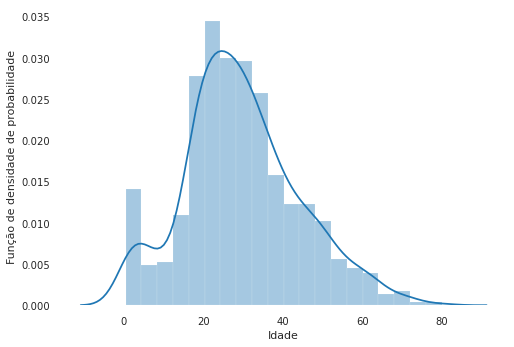

In [26]:
sns.distplot(df_train["Age"])
plt.xlabel("Idade")
plt.ylabel("Função de densidade de probabilidade")

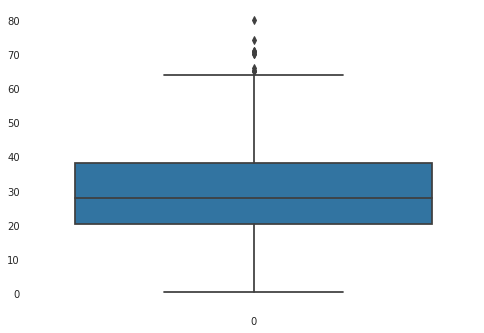

In [27]:
sns.boxplot(data=df_train["Age"])

Com base nos gráficos acima, é provável que idades superiores a 70 anos sejam outliers. 

<h2>Tarifas dos passageiros.</h2>

Text(0, 0.5, 'Função de densidade de probabilidade')

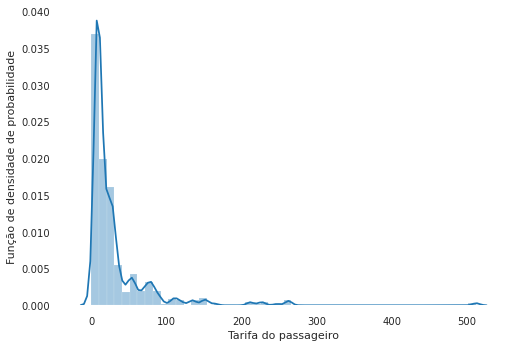

In [28]:
sns.distplot(df_train["Fare"])
plt.xlabel("Tarifa do passageiro")
plt.ylabel("Função de densidade de probabilidade")

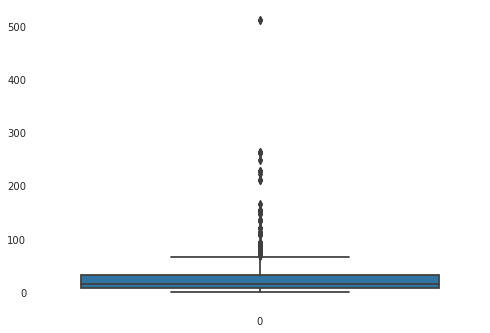

In [29]:
sns.boxplot(data=df_train["Fare"])

<h2>Número de irmãos/cônjuges a bordo do Titanic.</h2>

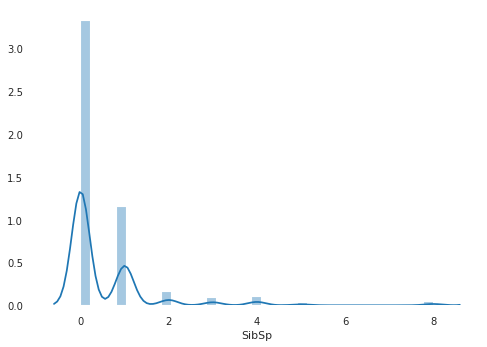

In [30]:
sns.distplot(df_train["SibSp"])

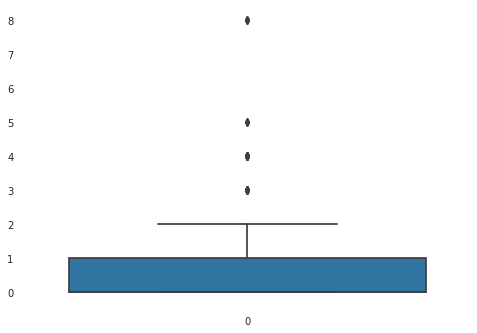

In [31]:
sns.boxplot(data=df_train["SibSp"])

In [32]:
gender = df_train[["Sex", "Survived", "Age"]].groupby(["Sex","Survived"]).count()

In [ ]:
gender

A figura abaixo ilustra a quantidade de pessoas, por gênero, que sobreviveram ou não.

Text(0, 0.5, 'Gênero')

<Figure size 720x432 with 0 Axes>

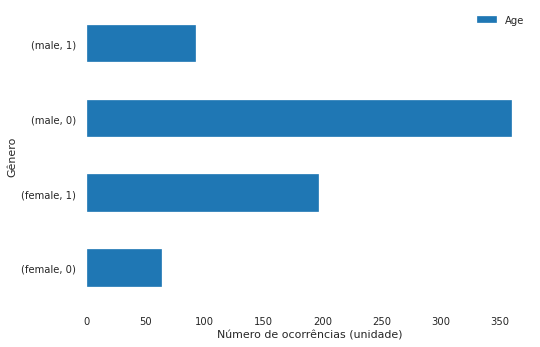

In [33]:
plt.figure(figsize=(10,6))
gender.plot.barh()
plt.xlabel("Número de ocorrências (unidade)")
plt.ylabel("Gênero")

Distribuição dos sobreviventes para as classes de passageiros.

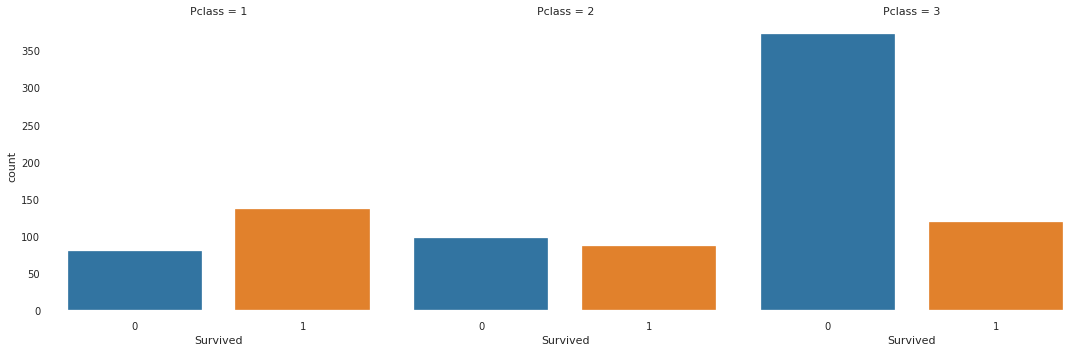

In [34]:
sns.catplot("Survived", col="Pclass", kind="count", data=df_train)

A maioria dos sobreviventes estão na classe 1. Por sua vez, a classe 3 concentra a maior parte das pessoas que não sobreviveram. 

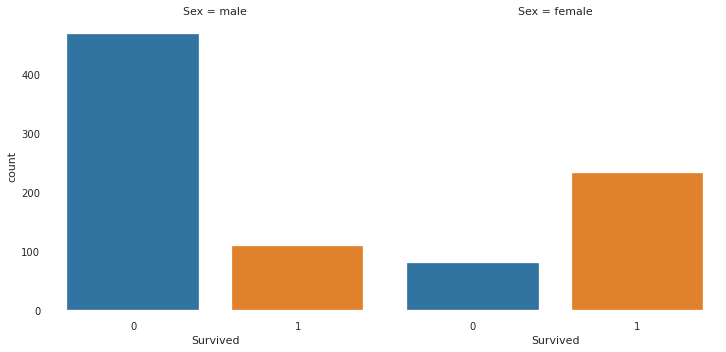

In [35]:
sns.catplot("Survived", col="Sex", kind="count", data=df_train)

Morreram mais homens do que mulheres.

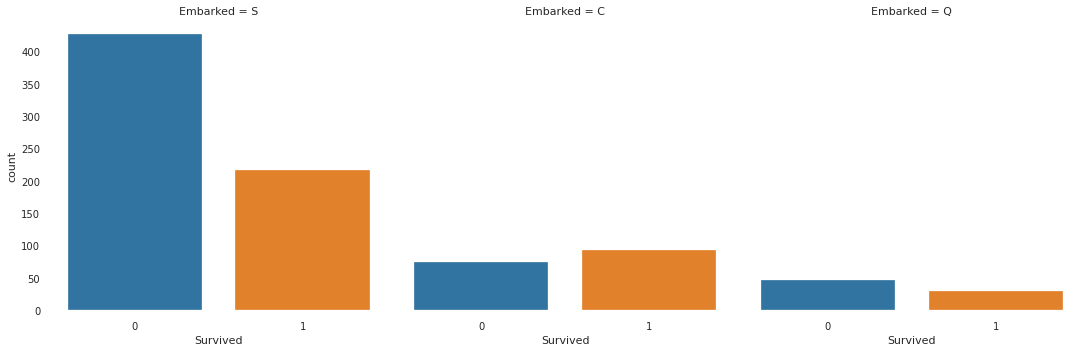

In [36]:
sns.catplot("Survived", col="Embarked", kind="count", data=df_train)

A maioria das vítimas fatais embarcou pelo embarque "S", assim como maior parte dos sobreviventes. Provavelmente, a maioria dos passageiros embarcou no navio através do embarque "S". 

<h2>Exemplos duplicados</h2>

In [37]:
df_train.duplicated().sum()

0

<h2>Verifica a ocorrência de valores ausentes</h2>

In [38]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [39]:
df_train.isna().sum()/df_train["PassengerId"].count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

<h2>Interpolar dados ausentes</h2>

In [40]:
df_train["Age"].interpolate(method="pad",inplace=True)

In [41]:
df_train["Cabin"].interpolate(method="pad",inplace=True)

In [42]:
df_train["Embarked"].interpolate(method="pad",inplace=True)

Verifica se ainda existem valores ausentes.

In [43]:
df_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          1
Embarked       0
dtype: int64

Curiosamente, um valor ausente persiste na coluna "Cabin". Infelizmente, não consegui identificar o motivo para essa permanência. O código a seguir descarta esse valor ausente. 

In [44]:
df_train.dropna(inplace=True)

<h1>Dados desbalanceados?</h1>

In [45]:
df_train.groupby(by="Survived")["Survived"].count()/df_train["Survived"].count()

Survived
0    0.61573
1    0.38427
Name: Survived, dtype: float64

Os dados estão desbalanceados, pois a classe "0" representa mais de 60% dos dados.

<h2>Valores incorretos?</h2>

In [46]:
for col in df_train.columns:
  print("Valores da coluna {0}: {1}.".format(col,df_train[col].unique()))

Valores da coluna PassengerId: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240

O pandas-profiling mostrou que existem valores zero para a tarifa dos passageiros, o que parece curioso.

Verifica quais exemplos contêm zero na tarifa do passageiro.

In [47]:
df_train[df_train["Fare"] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,C49,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,C99,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,45.0,0,0,239853,0.0,D7,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,B58 B60,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,33.0,0,0,239853,0.0,C78,S
466,467,0,2,"Campbell, Mr. William",male,38.0,0,0,239853,0.0,E63,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,9.0,0,0,239854,0.0,A14,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,D20,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,32.0,0,0,112052,0.0,B50,S


<h2>Reseta o indíce do dataframe</h2>

In [48]:
df_train = df_train.reset_index(drop=True)

<h2>Feature encoding</h2>

Os atributos categóricos precisam ser convertidos em valores numéricos para que os algoritmos possam interpretá-los.

In [49]:
ohe = OneHotEncoder(sparse=True)

In [50]:
df_train = pd.concat([df_train,pd.DataFrame(ohe.fit_transform(df_train["Sex"].values.reshape(-1,1)).toarray(), columns=["sex_m", "sex_f"])], axis=1)

Há uma grande quantidade de cabines únicas, o que torna a conversão desse atributo em valores numéricos muito desafiador. Ao observar os valores únicos para o identificador da cabine, identifiquei que existe um padrão na formação dos identificadores: todos parecem começar com uma letra. Essa letra pode identificar algum grupo de cabines. Uma possibilidade seria considerar os grupos de cabines, ao invés de cabines específicas. 

Cria uma nova coluna que contém somente a letra do identificador de cada cabine.

In [51]:
df_train["Cabin_first_letter"] = df_train["Cabin"].apply(lambda x: x[0])

Seleciona os valores únicos contidos na coluna recém criada.

In [52]:
columns_names = [x for x in df_train["Cabin_first_letter"].unique()]

Ordena em ordem crescente os valores selecionados anteriormente.

In [53]:
columns_cabin = sorted(columns_names)

In [54]:
df_train = pd.concat([df_train,pd.DataFrame(ohe.fit_transform(df_train["Cabin_first_letter"].values.reshape(-1,1)).toarray(), columns=columns_cabin)], axis=1)

Prepara os dados da coluna "Embarked" para serem convertidos em valores numéricos.

In [55]:
columns_embaked = [x for x in df_train["Embarked"].unique()]

In [56]:
columns_embaked = sorted(columns_embaked)

In [57]:
df_train = pd.concat([df_train,pd.DataFrame(ohe.fit_transform(df_train["Embarked"].values.reshape(-1,1)).toarray(), columns=columns_embaked)], axis=1)

<h2>Descarta os atributos potencialmente irrelevantes</h2>

Apaga os atributos categóricos que foram substituídos e/ou parecem irrelevantes.

In [58]:
df_train.drop(["Cabin","Embarked", "Sex","Cabin_first_letter", "PassengerId","Name", "Ticket"], axis=1, inplace=True)

Uma tarifa zero é pouco provável.

In [59]:
df_train.drop(df_train[df_train["Fare"] == 0].index, inplace=True)

In [60]:
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,sex_m,sex_f,A,B,C,D,E,F,G,T,C,Q,S
0,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.4583,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<h2>Label encoding</h2>

Converte as palavras "Yes" e "No" em 0 e 1, respectivamente.

In [61]:
le = LabelEncoder()

In [62]:
df_train["Survived"] = le.fit_transform(df_train["Survived"])

<h2>Normaliza os valores</h2>

In [63]:
scaler = MinMaxScaler(feature_range=[0,1])

In [64]:
X = df_train.drop("Survived", axis=1)
y = df_train["Survived"]

In [65]:
X = scaler.fit_transform(X)

<h2>Importância dos atributos</h2>

In [66]:
rfc = RandomForestClassifier()

In [67]:
rfc.fit(X, y)

RandomForestClassifier()

In [68]:
rfc.feature_importances_

array([0.08552028, 0.2186485 , 0.04543496, 0.03676789, 0.21454571,
       0.14781805, 0.11938168, 0.01225547, 0.01894374, 0.01884989,
       0.0133477 , 0.0143745 , 0.00924817, 0.00656515, 0.0004547 ,
       0.01552402, 0.00737261, 0.01494699])

In [69]:
df_train.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'sex_m', 'sex_f',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'C', 'Q', 'S'],
      dtype='object')

In [70]:
df_feature_importance = pd.DataFrame({"feature_importance":rfc.feature_importances_*100, "Columns":df_train.columns[1:]})

(0.0, 100.0)

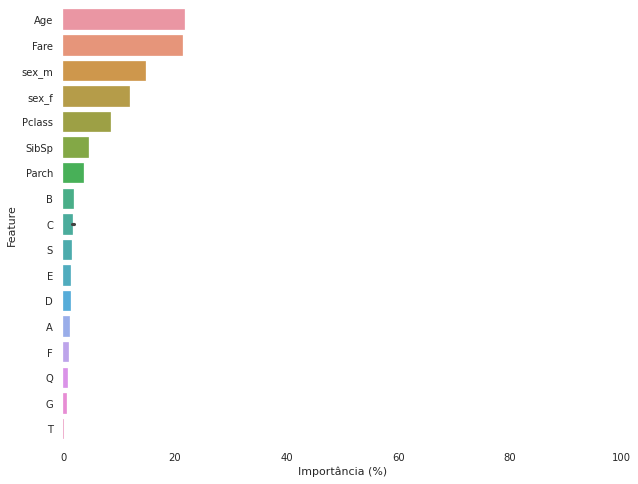

In [71]:
plt.figure(figsize=(10,8))
sns.barplot(data=df_feature_importance.sort_values(by="feature_importance", ascending=False), y="Columns", x="feature_importance")
plt.ylabel("Feature")
plt.xlabel("Importância (%)")
plt.xlim(0, 100)

<h2>Reamostragem dos dados</h2>

In [72]:
X = df_train[["Age", "Fare", "sex_m", "sex_f", "Pclass"]]
y = df_train["Survived"]

In [73]:
smote = SMOTE()

In [74]:
X_resampled, y_resampled = smote.fit_resample(X, y)

In [75]:
X_resampled.shape

(1068, 5)

In [76]:
y_resampled.shape

(1068,)

In [77]:
rfc = RandomForestClassifier()
svm = SVC()
knn = KNeighborsClassifier(n_neighbors=5)

In [78]:
classifiers = [rfc, svm, knn]

Avaliação dos classificadores.

In [79]:
df_results = pd.DataFrame()
for clf, clf_name in zip(classifiers, ["Random Forest", "SVM", "k-NN"]):
  clf_results = cross_validate(clf, X_resampled, y_resampled, cv=10, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"])
  df_temp = pd.DataFrame({"metric":list({x:np.mean(clf_results[x]) for x in clf_results}.keys())[2:], "performance":list({x:np.mean(clf_results[x]) for x in clf_results}.values())[2:]})
  df_temp["classifier"] = clf_name
  df_results = pd.concat([df_results,df_temp])

In [80]:
df_results["metric"].replace("test_accuracy", "Accuracy", inplace=True)
df_results["metric"].replace("test_precision_macro", "Precision macro", inplace=True)
df_results["metric"].replace("test_recall_macro", "Recall macro", inplace=True)
df_results["metric"].replace("test_f1_macro", "F1 macro", inplace=True)
df_results["performance"] = df_results["performance"] * 100

In [81]:
df_results

,metric,performance,classifier
0,Accuracy,83.528478,Random Forest
1,Precision macro,83.808833,Random Forest
2,Recall macro,83.537736,Random Forest
3,F1 macro,83.483120,Random Forest
0,Accuracy,66.296068,SVM
1,Precision macro,66.417707,SVM
2,Recall macro,66.301537,SVM
3,F1 macro,66.213239,SVM
0,Accuracy,72.014636,k-NN
1,Precision macro,72.262249,k-NN


(0.0, 100.0)

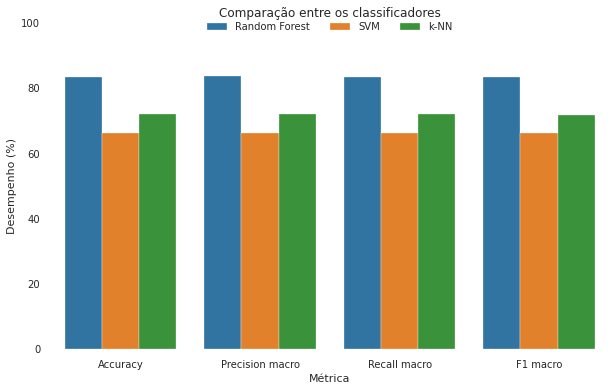

In [82]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="metric", y="performance", hue="classifier")
plt.ylabel("Desempenho (%)")
plt.xlabel("Métrica")
plt.title("Comparação entre os classificadores")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.03), ncol=3, fancybox=True, shadow=True)
plt.ylim(0, 100)

<h2>Preparação dos dados de teste</h2>

In [83]:
def dataCleaning(dataset):
    dataset["Age"].interpolate(method="pad",inplace=True)
    dataset["Cabin"].interpolate(method="pad",inplace=True)
    dataset["Embarked"].interpolate(method="pad",inplace=True)
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop=True)
    return dataset

In [84]:
def dataPreparation(dataset):
    ohe = OneHotEncoder(sparse=True)
    dataset = pd.concat([dataset,pd.DataFrame(ohe.fit_transform(dataset["Sex"].values.reshape(-1,1)).toarray(), columns=["sex_m", "sex_f"])], axis=1)
    dataset["Cabin_first_letter"] = dataset["Cabin"].apply(lambda x: x[0])
    columns_names = [x for x in dataset["Cabin_first_letter"].unique()]
    columns_cabin = sorted(columns_names)
    dataset = pd.concat([dataset,pd.DataFrame(ohe.fit_transform(dataset["Cabin_first_letter"].values.reshape(-1,1)).toarray(), columns=columns_cabin)], axis=1)
    columns_embaked = [x for x in dataset["Embarked"].unique()]
    columns_embaked = sorted(columns_embaked)
    dataset = pd.concat([dataset,pd.DataFrame(ohe.fit_transform(dataset["Embarked"].values.reshape(-1,1)).toarray(), columns=columns_embaked)], axis=1)
    dataset = dataset.drop(["Cabin","Embarked", "Sex","Cabin_first_letter", "PassengerId","Name", "Ticket"], axis=1)
    dataset = dataset.drop(dataset[dataset["Fare"] == 0].index)
    return dataset

In [85]:
df_test = dataCleaning(df_test)

In [86]:
df_test = dataPreparation(df_test)

In [87]:
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,sex_m,sex_f,A,B,C,D,E,F,G,C,Q,S
0,1,23.0,1,0,82.2667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,63.0,1,0,26.0000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,47.0,1,0,61.1750,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2,24.0,1,0,27.7208,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2,35.0,0,0,12.3500,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [88]:
scaler = MinMaxScaler(feature_range=[0,1])

Normaliza os dados de teste com os atributos selecionados anteriormente. 

In [92]:
df_test_scaled = scaler.fit_transform(df_test[["Age", "Fare", "sex_m", "sex_f", "Pclass"]])

In [93]:
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [95]:
predictions = rfc.predict(df_test_scaled)

<h2>Considerações finais</h2>

Uma série de análises foi conduzida a fim de identificar os atributos mais relevantes. Ao fim destes testes, cincos atributos foram selecionados para construção de três modelos. Dos três classificadores analisados, o Random Forest foi único que apresentou um desempenho promissor, pois, nos dados de treino, conseguiu superar os 80% em todas as métricas avaliadas. Esses resultados preliminares sugerem que há potencial no modelo criado, mas serão necessários mais dados para buscar um desempenho melhor.